# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import sympy as sm
from ipywidgets import interact, widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Basic Solow Model

The Basic Solow Model is an exogenous model for a closed economy. The production is determined by two factors in the supply side: physical capital, K, and labor, L. Physical capital is things like machines, factories, buildings and so on, where the labor is the population in the society. Capital and labor accumulate over time. The production can either be consumed today or invested in machines which will increase the production tomorrow. 

**The equations for The Basic Solow Model**
$$Y_t=BK^\alpha_tL^{1-\alpha}_t, \quad 0<\alpha<1 \tag{1}$$
$$K_{t+1}=(1-\delta)K_t+S_t, \quad 0<\delta<1 \tag{2}$$
$$S_t=sY_t, \quad 0<s<1 \tag{3}$$
$$L_{t+1}=(1+n)L_t \tag{4}$$
$$r_t=\alpha B\left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{5}$$
$$w_t=(1-\alpha)B\left(\frac{K_t}{L_t}\right)^\alpha \tag{6}$$


Where $y_t\equiv\frac{Y_t}{L_t}$ and $k_t\equiv\frac{K_t}{L_t}$.


## Analytical solution

We start by using sympy to find an analytical expression for steady state in The Basic Solow Model. This means that we will solve:
$$k^*=\frac{1}{1+n}(sBk^{*\alpha}+(1-{\delta})k^*)$$
$$y^*=B(k^*)^\alpha$$

In [61]:
#Define symbols
kstar = sm.symbols('k^*')
ystar = sm.symbols('y^*')
n = sm.symbols('n')
s = sm.symbols('s')
B = sm.symbols('B')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')

In [62]:
#Find steady state for k
ssk = sm.Eq(kstar,((s*B*kstar**alpha+(1-delta)*kstar)/(1+n)))
ss_k = sm.solve(ssk,kstar)[0]
s_s_k = sm.Eq(kstar,ss_k)

#Find steady state for y
ssy = sm.Eq(ystar,((B*ss_k**alpha)))
ss_y = sm.solve(ssy,ystar)[0]
s_s_y = sm.Eq(ystar,ss_y)

#Show the results
display(s_s_k)
display(s_s_y)

Eq(k^*, (B*s/(delta + n))**(-1/(alpha - 1)))

Eq(y^*, B*((B*s/(delta + n))**(-1/(alpha - 1)))**alpha)

In [63]:
#We will now turn our solution into a Python function
ssk_func = sm.lambdify((B, s, delta, n, alpha), ss_k)

ssy_func = sm.lambdify((B, s, delta, n, alpha), ss_y)

#We will now evaluate the functions with specific parameters:
ssk_value = ssk_func(1, 0.2, 0.05, 0.02, 1/3)

ssy_value = ssy_func(1, 0.2, 0.05, 0.02, 1/3)

# Print the values
print('Steady state value of capital: {:.3f}'.format(ssk_value))
print('Steady state value of output: {:.3f}'.format(ssy_value))

Steady state value of capital: 4.829
Steady state value of output: 1.690


## Numerical solution

We will now find steadt state by the numerical solution of The Basic Solow Model. 
To do this, we start by defining the parameters. Then we find steady state for k and y using the root finding optimizer, optimize.root_scalar, where we use the method brentq. Brentq is in general considered as the best of the rootfinding methods. This is because that is is a method with a fast convergence speed and it is robust against different types of functions. 

In [64]:
#The parameters
B = 1
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

#Finding steady state with an optimizer for k
solow_ss_k = lambda ss_k: ss_k - ((s*B*ss_k**alpha+(1-delta)*ss_k)/(1+n))
result_k = optimize.root_scalar(solow_ss_k,bracket=[0.1,100],method='brentq')

#Finding steady state with an optimizer for y
solow_ss_y = lambda ss_y: ss_y - (B*result_k.root**alpha)
result_y = optimize.root_scalar(solow_ss_y,bracket=[0.1,100],method='brentq')


print('Steady state value of capital: {:.3f}'.format(result_k.root))
print('Steady state value of output: {:.3f}'.format(result_y.root))



Steady state value of capital: 4.829
Steady state value of output: 1.690


As we can see, the numerical solution gives the same steady state values as the analytical solution. 

We will now make a Solow Diagram for The Basic Solow Model.

In [65]:
#The parameters
B = 1
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

def basic_solow_diagram(k: int, n: float, s: float, B: int, alpha: float, delta: float, kmax: int, kline: float):
    # Definition of the values of k, the growth rate of k and the diagonal line
    k_values = np.linspace(0, kmax, 100)
    k_growth = s * B * k_values**alpha
    diagonal = (n + delta) * k_values

    #  Calculation of steady state for capital per capita
    k_star = ((B*s)/(n+delta))**(-1/(alpha-1))

    # The figure size and the two graphs
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, diagonal, label=r'$(n+\delta)k_t$', color='black')
    plt.plot(k_values, k_growth, label=r'$y_t = sBk_t^{\alpha}$', color='mediumorchid')

    #The steady state point, the starting point and the labels:
    plt.axvline(x=kline, linestyle='--', color='royalblue', label=r'$k_0$')
    plt.axvline(x=k_star, linestyle='--', color='gold', label=r'$k*$')
    plt.xlim(0, kmax)
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.legend()
    plt.title('The Basic Solow Diagram')
    plt.grid(True)
    
# Creating the interactive plot
interact(basic_solow_diagram,
    k=widgets.fixed(0),
    alpha=widgets.FloatSlider(description=r'α', min=0, max=0.9, step=0.05, value=1/3),
    delta=widgets.FloatSlider(description=r'δ', min=0, max=0.1, step=0.01, value=0.05),
    s=widgets.FloatSlider(description='s', min=0.01, max=0.8, step=0.05, value=0.2),
    n=widgets.FloatSlider(description='n', min=0.01, max=0.1, step=0.005, value=0.02),
    B=widgets.fixed(1),
    kmax=widgets.IntSlider(description='x axis', min=1, max=30, step=10, value=100),
    kline=widgets.FloatSlider(description='k_0', min=0, max=100, step=0.1, value=20))

# Showing plot
plt.show(basic_solow_diagram)

interactive(children=(FloatSlider(value=0.02, description='n', max=0.1, min=0.01, step=0.005), FloatSlider(val…

In the basic Solow diagram above, it can be seen that there is convergens to steady state no matter the starting point. If $k_0$ is smaller than $k^*$, then it will increase until it reaches $k^*$. In the same way, if $k_0$ is larger than $k^*$, then it will decrease until it reaches $k^*$. In that way there will always be convergens until steady state, $k^*$.
It can be seen in the figure, that when the population growth, n, increases, then the steady state moves towards the lower left corner. Furthermore, it can be seen that when the savings, s, increases steady state will move against the upper right corner. 

# Solow Model with technological growth

We will now do an extension of the Basic Solow Model where we include the tecnological growthrate. A problem with the Basic Solow Model is that is no positive growth in the long run, due to diminishing marginal product w.r.t. capital. This does not fit well with empirical evidence from Western countries. By including technological growth the model will be more close to reality. 

**The equations for The Solow Model with harrod-neutral technological growth**
$$Y_t=K^\alpha_t(A_tL_t)^{1-\alpha}, \quad 0<\alpha<1 \tag{1}$$
$$K_{t+1}=(1-\delta)K_t+S_t, \quad 0<\delta<1 \tag{2}$$
$$S_t=sY_t, \quad 0<s<1 \tag{3}$$
$$L_{t+1}=(1+n)L_t \tag{4}$$
$$A_{t+1}=(1+g)A_t \tag{5}$$
$$r_t=\alpha B\left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{6}$$
$$w_t=(1-\alpha)B\left(\frac{K_t}{L_t}\right)^\alpha \tag{7}$$


Where $y_t\equiv\frac{Y_t}{L_t}$ and $k_t\equiv\frac{K_t}{L_t}$.

 We start by using sympy to find an analytical expression for steady state in The Solow Model with technological growth. This means that we will solve:
$$\tilde k^*=\frac{1}{(1+n)(1+g)}(s (\tilde k^*)^\alpha+(1-{\delta})\tilde k^*)$$
$$\tilde y^*=(\tilde k^*)^\alpha$$

In [66]:
#Define symbols
kstar = sm.symbols('k^*')
ystar = sm.symbols('y^*')
n = sm.symbols('n')
s = sm.symbols('s')
g = sm.symbols('g')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')

In [67]:
#Find steady state for k
ssk_t = sm.Eq(kstar,((s*kstar**alpha+(1-delta)*kstar)/((1+n)*(1+g))))
ss_k_t = sm.solve(ssk_t,kstar)[0]
s_s_k_t = sm.Eq(kstar,ss_k_t)

#Find steady state for y
ssy_t = sm.Eq(ystar,((ss_k_t**alpha)))
ss_y_t = sm.solve(ssy_t,ystar)[0]
s_s_y_t = sm.Eq(ystar,ss_y_t)

#Show the results
display(s_s_k_t)
display(s_s_y_t)

Eq(k^*, ((delta + g*n + g + n)/s)**(1/(alpha - 1)))

Eq(y^*, (((delta + g*n + g + n)/s)**(1/(alpha - 1)))**alpha)

In [68]:
#We will now turn our solution into a Python function
ssk_func_t = sm.lambdify((g, s, delta, n, alpha), ss_k_t)

ssy_func_t = sm.lambdify((g, s, delta, n, alpha), ss_y_t)

#We will now evaluate the functions with specific parameters:
ssk_value_t = ssk_func_t(0.02, 0.2, 0.05, 0.02, 1/3)

ssy_value_t = ssy_func_t(0.02, 0.2, 0.05, 0.02, 1/3)

# Print the values
print('Steady state value of capital: {:.3f}'.format(ssk_value_t))
print('Steady state value of output: {:.3f}'.format(ssy_value_t))

Steady state value of capital: 3.291
Steady state value of output: 1.487


We will now find the steady state by the numerical solution of The Solow Model with technological growth. We will use the same method as we did for The Basic Solow Model above.

In [69]:
#The parameters
g = 0.02
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

#Finding steady state with an optimizer for k
solow_ss_k_t = lambda ss_k_t: ss_k_t - ((s*ss_k_t**alpha+(1-delta)*ss_k_t)/((1+n)*(1+g)))
result_k_t = optimize.root_scalar(solow_ss_k_t,bracket=[0.1,100],method='brentq')

#Finding steady state with an optimizer for y
solow_ss_y_t = lambda ss_y_t: ss_y_t - (result_k_t.root**alpha)
result_y_t = optimize.root_scalar(solow_ss_y_t,bracket=[0.1,100],method='brentq')


print('Steady state value of capital: {:.3f}'.format(result_k_t.root))
print('Steady state value of output: {:.3f}'.format(result_y_t.root))

Steady state value of capital: 3.291
Steady state value of output: 1.487


In [70]:
#The parameters
g = 0.02
s = 0.2
delta = 0.05
n = 0.02
alpha = 1/3

def solow_diagram_t(k: int, n: float, s: float, g: float, alpha: float, delta: float, kmax_t: int, kline_t: float):
    # Definition of the values of k, the growth rate of k and the diagonal line
    k_values_t = np.linspace(0, kmax_t, 1000)
    k_growth_t = s * k_values_t**alpha
    diagonal_t = (n + g + delta + n*g) * k_values_t

    #  Calculation of steady state for capital per capita
    k_star_t = ((delta+g*n+g+n)/(s))**(1/(alpha-1))

    # The figure size and the two graphs
    plt.figure(figsize=(8, 5))
    plt.plot(k_values_t, diagonal_t, label=r'$(\delta+g*n+g+n)k_t$', color='black')
    plt.plot(k_values_t, k_growth_t, label=r'$y_t = sk_t^{\alpha}$', color='mediumorchid')

    #The steady state point, the starting point and the labels:
    plt.axvline(x=kline_t, linestyle='--', color='royalblue', label=r'$k_0$')
    plt.axvline(x=k_star_t, linestyle='--', color='gold', label=r'$k*$')
    plt.xlim(0, kmax_t)
    plt.xlabel('$\~{k}_t$')
    plt.ylabel('$\~{k}_{t+1}$')
    plt.legend()
    plt.title('The Solow Diagram with technological growth')
    plt.grid(True)
    
# Creating the interactive plot
interact(solow_diagram_t,
    k=widgets.fixed(0),
    alpha=widgets.FloatSlider(description=r'α', min=0, max=0.9, step=0.05, value=1/3),
    delta=widgets.FloatSlider(description=r'δ', min=0, max=0.1, step=0.01, value=0.05),
    s=widgets.FloatSlider(description='s', min=0.01, max=0.8, step=0.05, value=0.2),
    n=widgets.FloatSlider(description='n', min=0.01, max=0.1, step=0.005, value=0.02),
    g=widgets.FloatSlider(description='g', min=0, max=0.8, step=0.002, value=0.02),
    kmax_t=widgets.IntSlider(description='x axis', min=1, max=30, step=10, value=100),
    kline_t=widgets.FloatSlider(description='k_0', min=0, max=100, step=0.1, value=20))

# Showing plot
plt.show(solow_diagram_t)

interactive(children=(FloatSlider(value=0.02, description='n', max=0.1, min=0.01, step=0.005), FloatSlider(val…

When the technological growth increases the steady state moves towards the lower left corner. 

# Shock to the saving rate

We will now consider a permanent shock to the saving rate, s, in The Solow Model with technological growth. A permanent shock to the saving rate will male an shift upwards in the curve. This can be seen, when we look at the equation for the curve:
$$y_t=sk_t^\alpha$$
In the figure below the change in the Solow Diagram with technological growth can be seen.

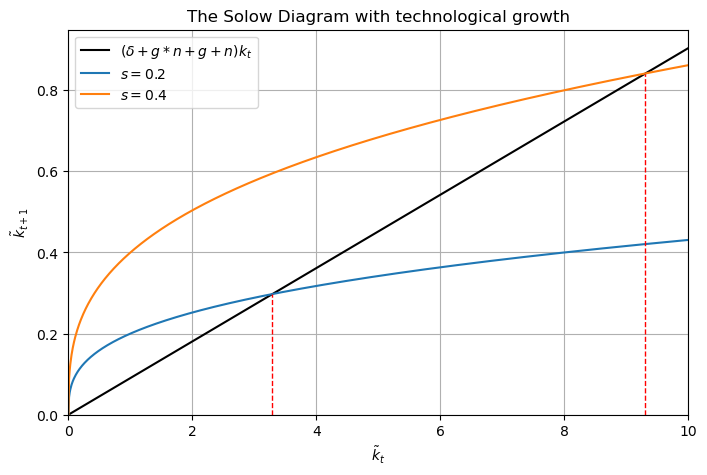

In [90]:
g = 0.02
delta = 0.05
n = 0.02
alpha = 1/3

def solow_diagram_s(kmax_s: int, kline_s: float, s_values: list):
    # Definition of the values of k and the diagonal line
    k_values_s = np.linspace(0, kmax_s, 1000)
    diagonal_s = (n + g + delta + n*g) * k_values_s

    # The figure size and the graph
    plt.figure(figsize=(8, 5))
    plt.plot(k_values_s, diagonal_s, label=r'$(\delta+g*n+g+n)k_t$', color='black')

    # Plotting for each value of s
    for s in s_values:
        k_growth_s = s * k_values_s**alpha
        plt.plot(k_values_s, k_growth_s, label=f'$s={s}$')

    # Finding intersection points
    intersection_points = []
    for s in s_values:
        k_growth_s = s * k_values_s**alpha
        intersection_point = np.argwhere(np.diff(np.sign(k_growth_s - diagonal_s))).flatten()
        intersection_points.append((k_values_s[intersection_point], k_growth_s[intersection_point]))
    
    # Plotting dotted lines where the diagonal line and the curves intersect each other
    for point in intersection_points:
        x = point[0]
        y = point[1]
        plt.vlines(x, 0, y, colors='r', linestyles='--', lw=1)  

    # Figure details
    plt.xlim(0, kmax_s)
    plt.ylim(0, None)
    plt.xlabel('$\~{k}_t$')
    plt.ylabel('$\~{k}_{t+1}$')
    plt.legend()
    plt.title('The Solow Diagram with technological growth')
    plt.grid(True)
    plt.show()

# Showing plot with two different values of s
solow_diagram_s(kmax_s=10, kline_s=5, s_values=[0.2, 0.4])

In the figure above we have considered a situation where the saving rate, s, increases from 0.2 to 0.4. This makes a shift upwards in the curve. Th mechanism behind this is that a higher saving rate means that a larger proportion of the income will be saved. This means that savings will exceed population growth, and thus capital intensity and GDP per capita will increase until the new steady state is reached.

# Conclusion

Add concise conclusion. 